In [1]:
!pip install pykan
!pip install torch
!pip install scikit-learn
!pip install matplotlib
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

KNOT-Supervised

In [2]:
import pandas as pd
import numpy as np
import torch
from kan import *
import copy

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Download data: https://colab.research.google.com/github/deepmind/mathematics_conjectures/blob/main/knot_theory.ipynb#scrollTo=l10N2ZbHu6Ob
df = pd.read_csv("./knot_theory_invariants.csv")
df.keys()

X = df[df.keys()[1:-1]].to_numpy()
Y = df[['signature']].to_numpy()

# normalize X
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean[np.newaxis,:])/X_std[np.newaxis,:]
input_normalier = [X_mean, X_std]

# normalize Y
max_signature = np.max(Y)
min_signature = np.min(Y)
Y = ((Y-min_signature)/2).astype(int)
n_class = int((max_signature-min_signature)/2+1)
output_normalier = [min_signature, 2]

dataset = {}
num = X.shape[0]
n_feature = X.shape[1]
train_ratio = 0.8
train_id_ = np.random.choice(num, int(num*train_ratio), replace=False)
test_id_ = np.array(list(set(range(num))-set(train_id_)))

dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(X[train_id_]).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(Y[train_id_][:,0]).type(torch.long).to(device)
dataset['test_input'] = torch.from_numpy(X[test_id_]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(Y[test_id_][:,0]).type(torch.long).to(device)
print(dataset['train_input'] ,dataset['train_label'])

cuda
tensor([[ 0.6270, -0.9154, -0.9285,  ..., -0.0368, -0.0073,  1.6227],
        [-0.6835,  0.0636, -0.9080,  ..., -0.0368, -0.0073,  1.6227],
        [ 1.5007,  0.0636, -1.4192,  ..., -0.0368, -0.0073,  1.6227],
        ...,
        [-0.6835, -0.9154, -0.2798,  ..., -0.0368, -0.0073,  1.6227],
        [-0.6835,  1.0426,  0.8949,  ..., -0.0368, -0.0073, -0.6162],
        [ 0.6270, -0.9154, -0.5552,  ..., -0.0368, -0.0073, -0.6162]],
       device='cuda:0') tensor([4, 4, 4,  ..., 6, 8, 5], device='cuda:0')


In [25]:
from kan import KAN
import torch
import torch.nn as nn

# Hyperparameters
input_dim = 17
hidden_dim = 1
output_dim = 14
grid_size = 5
k = 3
seed = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize the KAN model
model = KAN(width=[input_dim, hidden_dim, output_dim], grid=grid_size, k=k, seed=seed, device=device)


checkpoint directory created: ./model
saving model version 0.0


In [ ]:
# from kan.utils import create_dataset_from_data
# # Prepare dataset object for KAN (use all training data; validation can be optional)
# dataset = create_dataset_from_data(dataset['train_input'], dataset['train_label'], train_ratio=1.0, device='cpu')

In [29]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

# def test_acc():
#     return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

# model = KAN(width=[n_feature,1,n_class], grid=5, k=3, seed=seed, device=device)
model = KAN(width=[n_feature, 10, n_class], grid=10, k=3, seed=seed, device='cpu')
from kan.utils import create_dataset_from_data
# Prepare dataset object for KAN (use all training data; validation can be optional)
dataset = create_dataset_from_data(dataset['train_input'].to(device),
                                   dataset['train_label'].to(device),
                                   train_ratio=0.8, device='cpu')

model.fit(dataset, lamb=0.005, batch=1024, loss_fn = nn.CrossEntropyLoss(), metrics=[train_acc], display_metrics=['train_loss', 'reg', 'train_acc']);

checkpoint directory created: ./model
saving model version 0.0


 train_loss: 3.60e-01 | reg: 4.33e+01 | train_acc: 9.15e-01 |: 100%|█| 100/100 [08:25<00:00,  5.06s/

saving model version 0.1


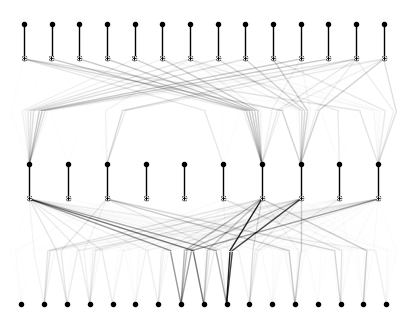

In [39]:
model.plot()

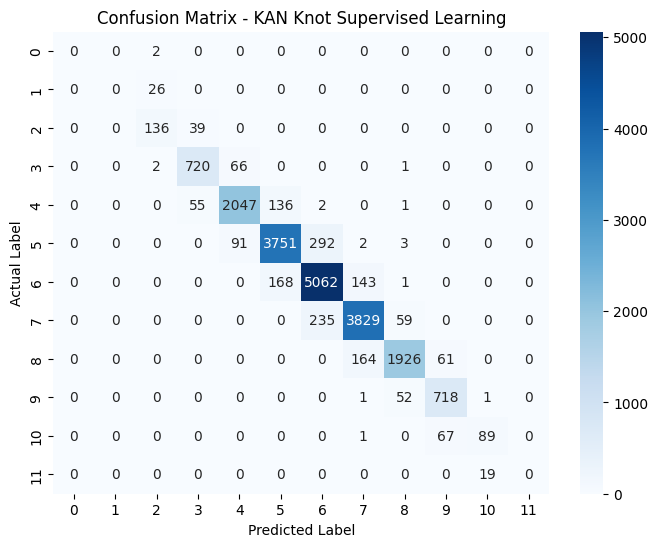

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - KAN Knot Supervised Learning")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [34]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_test, test_predictions))

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        26
           2       0.82      0.78      0.80       175
           3       0.88      0.91      0.90       789
           4       0.93      0.91      0.92      2241
           5       0.93      0.91      0.92      4139
           6       0.91      0.94      0.92      5374
           7       0.92      0.93      0.93      4123
           8       0.94      0.90      0.92      2151
           9       0.85      0.93      0.89       772
          10       0.82      0.57      0.67       157
          11       0.00      0.00      0.00        19

    accuracy                           0.92     19968
   macro avg       0.67      0.65      0.65     19968
weighted avg       0.91      0.92      0.91     19968



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Energy Time Series data


SLiding window

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('energy.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sliding window size
window_size = 24

# Create lagged features
for lag in range(1, window_size + 1):
    df[f'load_lag_{lag}'] = df['load'].shift(lag)

# Set the target as the load value 24 hours into the future
df['target_load'] = df['load'].shift(-24)

# Drop rows with NaNs (due to shifting)
df.dropna(inplace=True)

# Show the first few rows to verify
print(df.head())


             timestamp    load       temp  load_lag_1  load_lag_2  load_lag_3  \
24 2012-01-02 00:00:00  2458.0  43.666667      2639.0      2873.0      3129.0   
25 2012-01-02 01:00:00  2354.0  43.000000      2458.0      2639.0      2873.0   
26 2012-01-02 02:00:00  2294.0  42.666667      2354.0      2458.0      2639.0   
27 2012-01-02 03:00:00  2288.0  43.666667      2294.0      2354.0      2458.0   
28 2012-01-02 04:00:00  2353.0  43.000000      2288.0      2294.0      2354.0   

    load_lag_4  load_lag_5  load_lag_6  load_lag_7  ...  load_lag_16  \
24      3344.0      3513.0      3659.0      3717.0  ...       2916.0   
25      3129.0      3344.0      3513.0      3659.0  ...       3105.0   
26      2873.0      3129.0      3344.0      3513.0  ...       3174.0   
27      2639.0      2873.0      3129.0      3344.0  ...       3180.0   
28      2458.0      2639.0      2873.0      3129.0  ...       3184.0   

    load_lag_17  load_lag_18  load_lag_19  load_lag_20  load_lag_21  \
24       

In [ ]:
# Train-test split
train_data = df[df['timestamp'] < '2014-01-01']
test_data = df[df['timestamp'] >= '2014-01-01']

# Feature columns (all the lags)
feature_cols = [f'load_lag_{i}' for i in range(1, window_size + 1)]

# X and y for training and testing
X_train = train_data[feature_cols]
y_train = train_data['target_load']
X_test = test_data[feature_cols]
y_test = test_data['target_load']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(17520, 24) (17520,)
(8736, 24) (8736,)


In [ ]:
import torch
from kan import KAN
from kan.utils import create_dataset_from_data

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

# Prepare dataset for KAN
dataset = create_dataset_from_data(X_train_tensor, y_train_tensor, train_ratio=0.8, device='cpu')

# Initialize KAN with appropriate dimensions
model = KAN(width=[window_size, 20, 1], grid=10, k=3, seed=42, device='cpu')

# Train the model with MSE Loss
loss_fn = torch.nn.MSELoss()
model.fit(dataset, lamb=0.005, batch=1024, loss_fn=loss_fn, display_metrics=['train_loss', 'reg'])


checkpoint directory created: ./model
saving model version 0.0


 train_loss: 2.16e+02 | reg: 8.46e+01 |: 100%|████████████████████| 100/100 [02:54<00:00,  1.75s/it]

saving model version 0.1


{'train_loss': [array(264.3557, dtype=float32),
  array(249.0908, dtype=float32),
  array(239.29152, dtype=float32),
  array(239.84802, dtype=float32),
  array(226.38908, dtype=float32),
  array(223.13889, dtype=float32),
  array(214.2152, dtype=float32),
  array(225.71495, dtype=float32),
  array(212.8036, dtype=float32),
  array(224.25027, dtype=float32),
  array(224.81082, dtype=float32),
  array(232.02116, dtype=float32),
  array(226.34737, dtype=float32),
  array(225.8572, dtype=float32),
  array(222.79013, dtype=float32),
  array(233.27893, dtype=float32),
  array(227.64095, dtype=float32),
  array(224.26218, dtype=float32),
  array(238.67966, dtype=float32),
  array(220.22607, dtype=float32),
  array(235.33156, dtype=float32),
  array(234.65448, dtype=float32),
  array(227.8054, dtype=float32),
  array(225.7233, dtype=float32),
  array(229.79807, dtype=float32),
  array(214.50905, dtype=float32),
  array(217.66893, dtype=float32),
  array(228.98009, dtype=float32),
  array(221.3

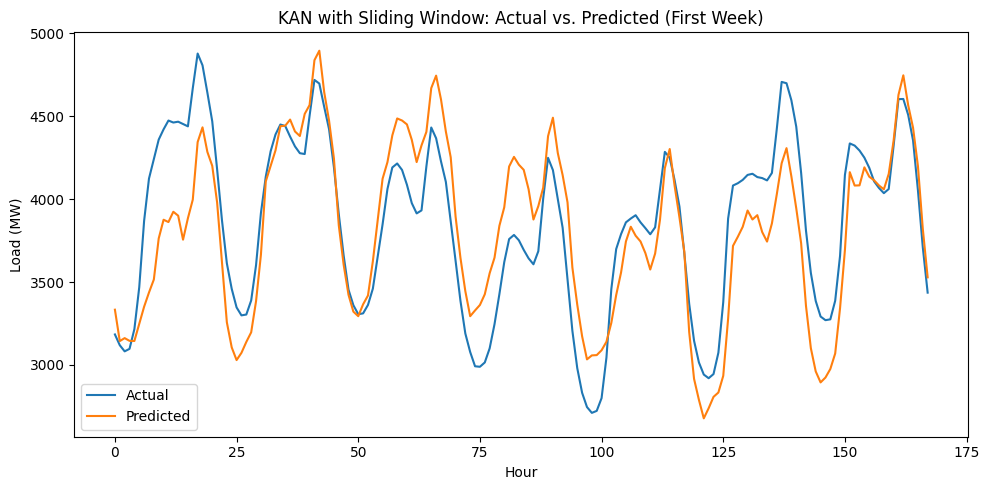

Sliding Window KAN RMSE: 233.21 MW


In [ ]:
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Convert back to NumPy for plotting
y_pred = y_pred_tensor.numpy().flatten()
y_actual = y_test.values.flatten()

# Plot the predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(y_actual[:24*7], label='Actual')
plt.plot(y_pred[:24*7], label='Predicted')
plt.title("KAN with Sliding Window: Actual vs. Predicted (First Week)")
plt.xlabel("Hour")
plt.ylabel("Load (MW)")
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f"Sliding Window KAN RMSE: {rmse:.2f} MW")


Updated KAN vs ARIMA vs LSTM

In [4]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('energy.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sliding window size
window_size = 24

# Create lagged features
for lag in range(1, window_size + 1):
    df[f'load_lag_{lag}'] = df['load'].shift(lag)

# Set the target as the load value 24 hours into the future
df['target_load'] = df['load'].shift(-24)

# Drop rows with NaNs (due to shifting)
df.dropna(inplace=True)

# Train-test split
train_data = df[df['timestamp'] < '2014-01-01']
test_data = df[df['timestamp'] >= '2014-01-01']

# Feature columns (all the lags)
feature_cols = [f'load_lag_{i}' for i in range(1, window_size + 1)]

# X and y for training and testing
X_train = train_data[feature_cols]
y_train = train_data['target_load']
X_test = test_data[feature_cols]
y_test = test_data['target_load']

# Set proper datetime index
y_train.index = train_data['timestamp']
y_test.index = test_data['timestamp']
y_train.index = pd.DatetimeIndex(y_train.index)
y_test.index = pd.DatetimeIndex(y_test.index)

# Set frequency explicitly
y_train.index.freq = 'H'
y_test.index.freq = 'H'


<ipython-input-4-b0858fe82463>:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y_train.index.freq = 'H'
<ipython-input-4-b0858fe82463>:42: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y_test.index.freq = 'H'


In [ ]:
print(X_train[0])
print(X_test.shape, y_test.shape)

[[0.22157165]
 [0.17842835]
 [0.14329738]
 [0.13035439]
 [0.13066256]
 [0.14607088]
 [0.17904468]
 [0.22804314]
 [0.28875193]
 [0.34699538]
 [0.36825886]
 [0.37010786]
 [0.37134052]
 [0.35993837]
 [0.35223421]
 [0.3568567 ]
 [0.46440678]
 [0.53559322]
 [0.51771957]
 [0.47272727]
 [0.42064715]
 [0.35439137]
 [0.27550077]
 [0.20338983]]
(8760, 24, 1) (8760,)


In [ ]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

17520 17520 8736 8736


KAN Model training

In [ ]:
import torch
from kan import KAN
from kan.utils import create_dataset_from_data

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

# Prepare dataset for KAN
dataset = create_dataset_from_data(X_train_tensor, y_train_tensor,  device='cpu')

# Initialize KAN with appropriate dimensions
model = KAN(width=[window_size, 20, 1], grid=10, k=3, seed=42, device='cpu')

# Train the model with MSE Loss
loss_fn = torch.nn.MSELoss()
model.fit(dataset, lamb=0.005, batch=1024, loss_fn=loss_fn, display_metrics=['train_loss', 'reg'])


checkpoint directory created: ./model
saving model version 0.0


 train_loss: 2.16e+02 | reg: 7.99e+01 |: 100%|████████████████████| 100/100 [02:52<00:00,  1.73s/it]

saving model version 0.1


{'train_loss': [array(264.35553, dtype=float32),
  array(252.44548, dtype=float32),
  array(241.2693, dtype=float32),
  array(239.95451, dtype=float32),
  array(229.60303, dtype=float32),
  array(227.25291, dtype=float32),
  array(219.24243, dtype=float32),
  array(227.47127, dtype=float32),
  array(213.21661, dtype=float32),
  array(224.97678, dtype=float32),
  array(225.67589, dtype=float32),
  array(233.47499, dtype=float32),
  array(226.59773, dtype=float32),
  array(226.23965, dtype=float32),
  array(223.43025, dtype=float32),
  array(234.04683, dtype=float32),
  array(227.73062, dtype=float32),
  array(224.57385, dtype=float32),
  array(239.80376, dtype=float32),
  array(220.37947, dtype=float32),
  array(235.72607, dtype=float32),
  array(236.06578, dtype=float32),
  array(229.74516, dtype=float32),
  array(226.3962, dtype=float32),
  array(231.01521, dtype=float32),
  array(214.60863, dtype=float32),
  array(217.75575, dtype=float32),
  array(230.55722, dtype=float32),
  array(

In [5]:

import torch
from kan import KAN
from kan.utils import create_dataset_from_data

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

# Prepare dataset for KAN
dataset = create_dataset_from_data(X_train_tensor, y_train_tensor,  device='cpu')

# Initialize KAN with appropriate dimensions
# Re-initialize with adjusted parameters
model = KAN(width=[window_size, 10, 1], grid=10, k=3, seed=42, device='cpu')

# Train with reduced lambda and more steps
loss_fn = torch.nn.MSELoss()
model.fit(dataset, lamb=0.0005, batch=1024, loss_fn=loss_fn, display_metrics=['train_loss', 'reg'], steps=100)

# Check the width again
print("Neuron Widths After Training: ", model.width)



checkpoint directory created: ./model
saving model version 0.0


 train_loss: 2.23e+02 | reg: 5.12e+01 |: 100%|████████████████████| 100/100 [02:04<00:00,  1.24s/it]

saving model version 0.1
Neuron Widths After Training:  [[24, 0], [10, 0], [1, 0]]


In [ ]:
import torch
test_input = torch.tensor(X_test.values, dtype=torch.float32)

# # Evaluate model
# model.eval()
# with torch.no_grad():
#     activations = model(test_input)

# print("Sample Activations:", activations[:5])

Sample Activations: tensor([[3290.2227],
        [3099.4185],
        [3113.8713],
        [3130.8557],
        [3140.1938]])


In [ ]:
# # Loop through all neurons in the hidden layer
# for i in range(10):
#     try:
#         model.suggest_symbolic(0, i, 0)
#         print(f"Suggested symbolic formula for neuron {i}: ", model.symbolic_formula())
#     except Exception as e:
#         print(f"Neuron {i} could not be symbolized: {e}")


  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        x    1.000000 -16.680128           1                1   -2.536026
1      sin    0.999999 -16.509974           2                2   -1.701995
2      1/x    0.999997 -16.181276           2                2   -1.636255
3      cos    0.999993 -15.826212           2                2   -1.565242
4     sqrt    0.999990 -15.600093           2                2   -1.520019
Suggested symbolic formula for neuron 0:  ([0], [x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11, x_12, x_13, x_14, x_15, x_16, x_17, x_18, x_19, x_20, x_21, x_22, x_23, x_24])
    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0          x    1.000001 -16.698301           1                1   -2.539660
1      x^0.5    0.999993 -15.806365           2                2   -1.561273
2       sqrt    0.999993 -15.806365           2                2   -1.561273
3    1/x^0.5    0.999986 -15.331923           2          

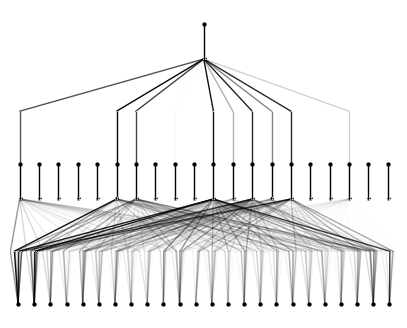

In [ ]:
model.plot()

In [15]:
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Convert back to NumPy for plotting
y_pred = y_pred_tensor.numpy().flatten()
y_actual = y_test.values.flatten()
timestamps = y_test.index


ARIMA

In [16]:
from statsmodels.tsa.arima.model import ARIMA

# Train the ARIMA model
model_arima = ARIMA(y_train, order=(24, 1, 0))
model_fit = model_arima.fit()

# Forecast the entire test set
forecast = model_fit.forecast(steps=len(y_test))
forecast = pd.Series(forecast, index=y_test.index)


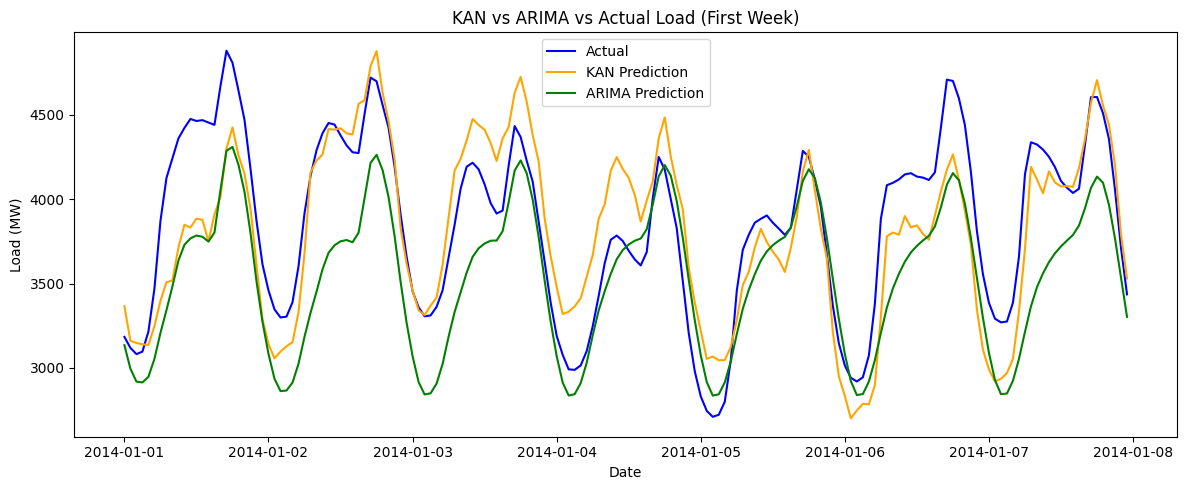

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(timestamps[:24*7], y_actual[:24*7], label="Actual", color='blue')
plt.plot(timestamps[:24*7], y_pred[:24*7], label="KAN Prediction", color='orange')
plt.plot(forecast.index[:24*7], forecast.values[:24*7], label="ARIMA Prediction", color='green')
plt.title("KAN vs ARIMA vs Actual Load (First Week)")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE for both
rmse_kan = np.sqrt(mean_squared_error(y_actual, y_pred))
rmse_arima = np.sqrt(mean_squared_error(y_test, forecast))

print(f"KAN Test RMSE: {rmse_kan:.2f} MW")
print(f"ARIMA Test RMSE: {rmse_arima:.2f} MW")


KAN Test RMSE: 232.99 MW
ARIMA Test RMSE: 542.37 MW


LSTM MOdel

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv('energy.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by='timestamp', inplace=True)

# Normalize the load column
scaler = MinMaxScaler(feature_range=(0, 1))
df[['load']] = scaler.fit_transform(df[['load']])

# Sliding window preparation (24 hours window)
window_size = 24
X, y = [], []

for i in range(len(df) - window_size):
    X.append(df['load'].iloc[i:i + window_size].values)
    y.append(df['load'].iloc[i + window_size])

X, y = np.array(X), np.array(y)

# Now we do the same split as KAN and ARIMA
train_data = df[df['timestamp'] < '2014-01-01']
test_data = df[df['timestamp'] >= '2014-01-01']

# Create the training and testing windows
train_size = len(train_data) - window_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape for LSTM (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training shape: {X_train.shape}, {y_train.shape}")
print(f"Testing shape: {X_test.shape}, {y_test.shape}")


Training shape: (17520, 24, 1), (17520,)
Testing shape: (8760, 24, 1), (8760,)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class EnhancedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EnhancedLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.batch_norm1 = nn.BatchNorm1d(window_size)
        self.dropout1 = nn.Dropout(0.2)

        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.batch_norm2 = nn.BatchNorm1d(window_size)
        self.dropout2 = nn.Dropout(0.2)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm1(x)
        lstm_out = self.batch_norm1(lstm_out)
        lstm_out = self.dropout1(lstm_out)

        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.batch_norm2(lstm_out)
        lstm_out = self.dropout2(lstm_out)

        predictions = self.fc(lstm_out[:, -1])
        return predictions

# Model parameters
input_dim = 1
hidden_dim = 64
output_dim = 1

# Instantiate the model
model_lstm = EnhancedLSTM(input_dim, hidden_dim, output_dim)
print(model_lstm)


EnhancedLSTM(
  (lstm1): LSTM(1, 64, batch_first=True)
  (batch_norm1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(64, 64, batch_first=True)
  (batch_norm2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# Define optimizer and loss
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
loss_fn = nn.MSELoss()

# Training Loop
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model_lstm.train()
    optimizer.zero_grad()
    outputs = model_lstm(X_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()
    train_losses.append(loss.item())
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [5/50], Loss: 0.4815
Epoch [10/50], Loss: 0.0871
Epoch [15/50], Loss: 0.1326
Epoch [20/50], Loss: 0.0756
Epoch [25/50], Loss: 0.0655
Epoch [30/50], Loss: 0.0677
Epoch [35/50], Loss: 0.0678
Epoch [40/50], Loss: 0.0646
Epoch [45/50], Loss: 0.0636
Epoch [50/50], Loss: 0.0625


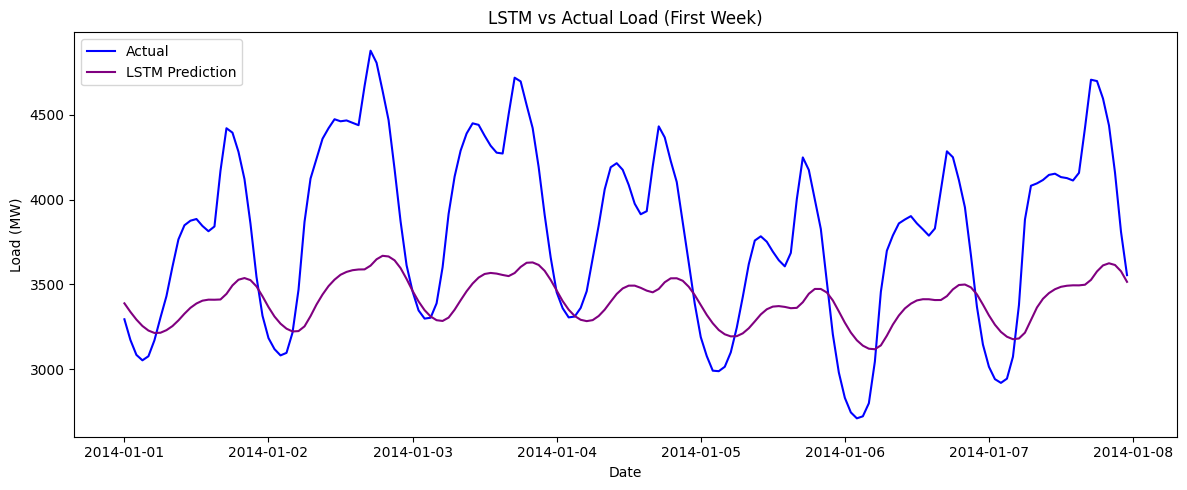

In [ ]:
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Make predictions
model_lstm.eval()
with torch.no_grad():
    y_pred_lstm = model_lstm(X_test_tensor)

# Inverse transform to get back to MW scale
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.numpy().reshape(-1, 1))
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Extract timestamps for the test set
timestamps = test_data['timestamp'].values

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(timestamps[:24*7], y_actual[:24*7], label="Actual", color='blue')
plt.plot(timestamps[:24*7], y_pred_lstm[:24*7], label="LSTM Prediction", color='purple')
plt.title("LSTM vs Actual Load (First Week)")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE for LSTM
rmse_lstm = np.sqrt(mean_squared_error(y_actual, y_pred_lstm))


# rmse_kan = np.sqrt(mean_squared_error(y_actual, y_pred[:len(y_actual)]))
# rmse_arima = np.sqrt(mean_squared_error(y_test, forecast[:len(y_test)]))

# Display the RMSE values
print(f"KAN Test RMSE: {rmse_kan:.2f} MW")
print(f"ARIMA Test RMSE: {rmse_arima:.2f} MW")
print(f"LSTM Test RMSE: {rmse_lstm:.2f} MW")

KAN Test RMSE: 232.99 MW
ARIMA Test RMSE: 542.37 MW
LSTM Test RMSE: 446.36 MW


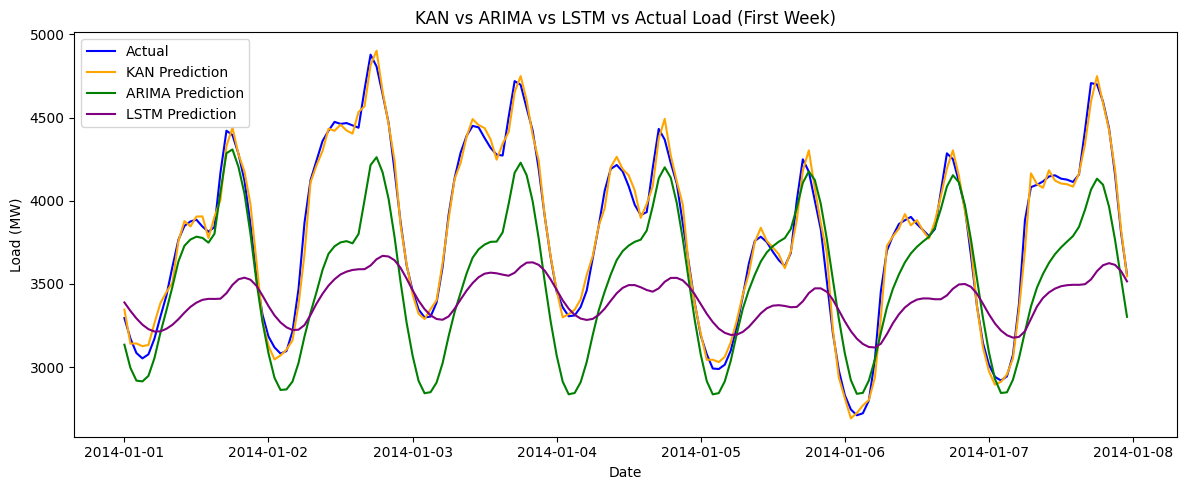

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Actual
plt.plot(timestamps[:24*7], y_actual[:24*7], label="Actual", color='blue')

# Plot KAN
plt.plot(timestamps[:24*7], y_pred[:24*7], label="KAN Prediction", color='orange')

# Plot ARIMA
plt.plot(forecast.index[:24*7], forecast.values[:24*7], label="ARIMA Prediction", color='green')

# Plot LSTM
plt.plot(timestamps[:24*7], y_pred_lstm[:24*7], label="LSTM Prediction", color='purple')

# Graph details
plt.title("KAN vs ARIMA vs LSTM vs Actual Load (First Week)")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.legend()
plt.tight_layout()
plt.show()
